# Introduction

The model is a Generative Adversarial Network (GAN) that generates molecular structures in the form of SMILES (Simplified Molecular Input Line Entry System) strings. The model consists of two main components: a generator and a discriminator.

The generator takes a latent vector as input and generates a sequence of tokens representing a SMILES string. The discriminator takes a SMILES string as input and outputs a probability that the string was generated by the real data distribution rather than the generator.

The generator and discriminator are trained together using a two-step process. In the first step, the discriminator is trained to distinguish between real and fake SMILES strings. In the second step, the generator is trained to generate SMILES strings that are indistinguishable from real SMILES strings by maximizing the reward function, which is the difference between the discriminator's output for the generated string and the baseline reward.

The training process involves the following steps:

1. Sample a batch of real SMILES strings from the training data.
2. Sample a batch of latent vectors from the latent space.
3. Generate a batch of fake SMILES strings using the generator and the latent vectors.
4. Train the discriminator to distinguish between real and fake SMILES strings.
5. Train the generator to generate SMILES strings that are indistinguishable from real SMILES strings by maximizing the reward function.
6. Repeat steps 2-5 for a specified number of training steps.

After training, the generator can be used to generate new molecular structures by sampling latent vectors from the latent space and passing them through the generator. The output of the generator is a sequence of tokens representing a SMILES string, which can be converted to a molecular structure using a chemical library such as RDKit.

In the code below, the `MolGen` class is used to train the GAN on a dataset of molecular structures in SMILES format. The `generate_n` method of the `MolGen` class can be used to generate a specified number of new molecular structures, and the `Chem.MolFromSmiles` function from the RDKit library can be used to convert the generated SMILES strings to molecular structures.

In [ ]:
%matplotlib inline


# Dataset

In [ ]:
import pandas as pd
df = pd.read_csv("/kaggle/input/qm9-dataset/qm9.csv")

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
!pip install -r /kaggle/input/qm9-dataset/requirement.txt

In [ ]:
!pip install --upgrade huggingface-hub==0.24.0

In [ ]:
!pip install rdkit

In [ ]:
import huggingface_hub
print(huggingface_hub.__version__)

# Loading Data and Initializing

In [ ]:
from rdkit import Chem
import sys
import importlib

# Add the dataset path to the Python path
sys.path.append('/kaggle/input/qm9-dataset')

# Import the MolGen class from model.py using importlib
model_module = importlib.import_module('model')
MolGen = model_module.MolGen

# load data
data = []
with open('/kaggle/input/qm9-dataset/qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# create model
gan_mol = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")


In [ ]:
gan_mol

# Training

In [ ]:
# create dataloader
loader = gan_mol.create_dataloader(data, batch_size=300, shuffle=True, num_workers=10)

# train model for 10000 steps
gan_mol.train_n_steps(loader, max_step=1000, evaluate_every=100)

In [ ]:
gan_mol.eval()

print('ok')

# Generating Smiles

In [ ]:
# After training
# generate Smiles molecules
smiles_list = gan_mol.generate_n(8)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)

In [ ]:
smiles_list

In [ ]:
mol_list

The none in `mol_list` indicates that it is not valid.

In [ ]:
# dir(gan_mol)

# Saving and loading model

In [ ]:
# Save model
import torch
torch.save(gan_mol.state_dict(), 'gan_mol_dict.pth')


In [ ]:
# Load model
gan_mol_n = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")

# Load the state dictionary into the new model
gan_mol_n.load_state_dict(torch.load('gan_mol_dict.pth'))

# Print the loaded model state to verify
# print("Loaded model state:", gan_mol_n.state_dict())

In [ ]:
gan_mol_n.eval()

print('ok')

In [ ]:
# After training
# generate Smiles molecules
smiles_list = gan_mol_n.generate_n(12)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)

#Using GNN to predict a molecular Property

GNNs are specifically designed to operate on graph structures, making them a natural fit for molecular data. In a GNN, atoms are represented as nodes, and chemical bonds are edges. GNNs learn by aggregating information from neighboring nodes and edges, making them ideal for understanding the relational properties within a molecule.

In [1]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [2]:
import sys
if sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c pyg pyg

/bin/bash: line 1: mamba: command not found


In [3]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.4 MB/s eta 0:00:00


In [4]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

In [6]:
# specify the local data path
HERE = Path(_dh[-1])
DATA = HERE /'output/'

In [ ]:
#!rm -rf /kaggle/working/*

In [7]:
# load dataset
qm9 = QM9(root=DATA)
qm9[0]

Extracting /content/output/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

**we will do prediction of the dipole moment property
    this dataset contains 19 different properties describing each molecule, such as dipole moment, different molecular energies, enthalpy and rotational constants.**
    

In [8]:
# get one regression target
y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0])

qm9 = qm9.shuffle()

# data split
data_size = 30000
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)


# normalizing the data
data_mean = qm9.data.y[0:train_index].mean()
data_std = qm9.data.y[0:train_index].std()

qm9.data.y = (qm9.data.y - data_mean) / data_std

# datasets into DataLoader
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warnin

**Defining a GCN and a GIN¶
The following two Python classes are the two GNNs we will consider in this tutorial. Both have 3 convolutional layers, one global pooling layer, linear layers, ReLU activation functions between the layers and a dropout layer.**

In [9]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network class with 3 convolutional layers and a linear layer"""

    def __init__(self, dim_h):
        """init method for GCN

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = torch.nn.Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [10]:
class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_h):
        """Initializing GIN class

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(11, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU())
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

**Training a GNN¶
When training a GNN (or any neural network), we have a training set, a validation set and a test set. The training set is used for training, the validation set is used to test the loss in each epoch not only on the training set but also on another dataset (monitor generalization performance). The test set is used to calculate the error of the fully trained model using a dataset, which has not been used during the whole training process.**

In [11]:
def training(loader, model, loss, optimizer):
    """Training one epoch

    Args:
        loader (DataLoader): loader (DataLoader): training data divided into batches
        model (nn.Module): GNN model to train on
        loss (nn.functional): loss function to use during training
        optimizer (torch.optim): optimizer during training

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader:
        optimizer.zero_grad()
        d.x = d.x.float()

        out = model(d)

        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss, model

In [12]:
def validation(loader, model, loss):
    """Validation

    Args:
        loader (DataLoader): validation set in batches
        model (nn.Module): current trained model
        loss (nn.functional): loss function

    Returns:
        float: validation loss
    """
    model.eval()
    val_loss = 0
    for d in loader:
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)
    return val_loss

In [13]:
@torch.no_grad()
def testing(loader, model):
    """Testing

    Args:
        loader (DataLoader): test dataset
        model (nn.Module): trained model

    Returns:
        float: test loss
    """
    loss = torch.nn.MSELoss()
    test_loss = 0
    test_target = numpy.empty((0))
    test_y_target = numpy.empty((0))
    for d in loader:
        out = model(d)
        # NOTE
        # out = out.view(d.y.size())
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        test_loss += l / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = numpy.concatenate((test_target, out.detach().numpy()[:, 0]))
        test_y_target = numpy.concatenate((test_y_target, d.y.detach().numpy()))

    return test_loss, test_target, test_y_target

In [14]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    """Training over all epochs

    Args:
        epochs (int): number of epochs to train for
        model (nn.Module): the current model
        train_loader (DataLoader): training data in batches
        val_loader (DataLoader): validation data in batches
        path (string): path to save the best model

    Returns:
        array: returning train and validation losses over all epochs, prediction and ground truth values for training data in the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, loss, optimizer)
        v_loss = validation(val_loader, model, loss)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for d in train_loader:
            out = model(d)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = numpy.concatenate((train_target, out.detach().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, d.y.detach().numpy()))

        train_loss[epoch] = epoch_loss.detach().numpy()
        val_loss[epoch] = v_loss.detach().numpy()

        # print current train and val loss
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
    return train_loss, val_loss, train_target, train_y_target

We have trained both models with 100 epochs and saved the best models under GCN_best-model-parameters.pt and GIN_best-model-parameters.pt. Since this takes some time, we reduced the number of epochs to 10 for this. The results and the plots below are based on the models trained for 100 epochs.

In [15]:
# training GCN for 10 epochs
epochs = 10

model = GCN(dim_h=128)

# Remember to change the path if you want to keep the previously trained model
gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GCN_model.pt"
)

Epoch: 0, Train loss: 0.9018599390983582, Val loss: 0.8917814493179321
Epoch: 2, Train loss: 0.8304069638252258, Val loss: 0.844386875629425
Epoch: 4, Train loss: 0.7996060252189636, Val loss: 0.8156452178955078
Epoch: 6, Train loss: 0.767340362071991, Val loss: 0.7918265461921692
Epoch: 8, Train loss: 0.7425493597984314, Val loss: 0.7591721415519714


In [16]:
# Training GIN for 10 epochs
model = GIN(dim_h=64)

# Remember to change the path if you want to keep the previously trained model
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GIN_model.pt"
)

Epoch: 0, Train loss: 0.6905983090400696, Val loss: 0.6415668725967407
Epoch: 2, Train loss: 0.5299733877182007, Val loss: 0.5240390300750732
Epoch: 4, Train loss: 0.4971580505371094, Val loss: 0.5057076811790466
Epoch: 6, Train loss: 0.4675258696079254, Val loss: 0.4191102087497711
Epoch: 8, Train loss: 0.44192153215408325, Val loss: 0.4180222153663635


**Evaluating the model¶
For evaluation, we use a validation dataset to find the best model and a test set, to test our model on unseen data. First, we plotted the losses of our training and validation sets. As expected, the GIN model has a lower training and validation loss.**

In [17]:
def plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss):
    """Plot the loss for each epoch

    Args:
        epochs (int): number of epochs
        train_loss (array): training losses for each epoch
        val_loss (array): validation losses for each epoch
    """
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    plt.plot(gin_train_loss, label="Train loss (GIN)")
    plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [18]:
def plot_targets(pred, ground_truth):
    """Plot true vs predicted value in a scatter plot

    Args:
        pred (array): predicted values
        ground_truth (array): ground truth values
    """
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

In [18]:
# Plot overall losses of GIN and GCN

plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss)

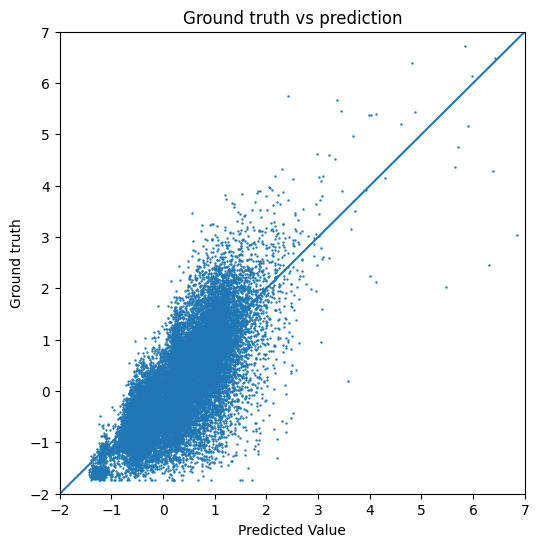

In [19]:
# Plot target and prediction for training data

plot_targets(gin_train_target, gin_train_y_target)

<ipython-input-21-d814b42fa80f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/GCN_model.pt"))


Test Loss for GCN: 0.7637976408004761


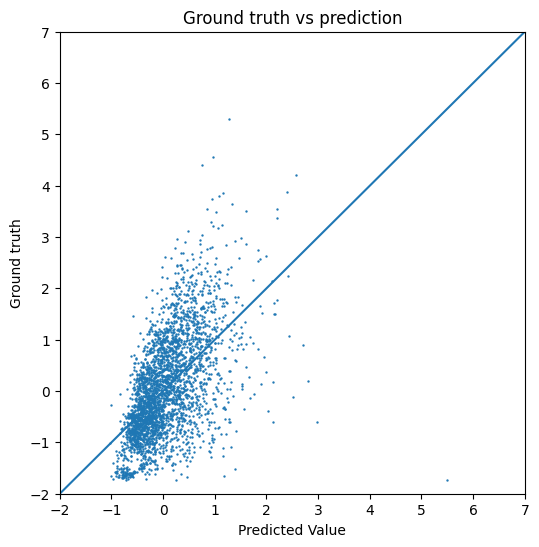

In [21]:
# Calculate test loss from the best GCN model (according to validation loss)

# load our model
model = GCN(dim_h=128)
model.load_state_dict(torch.load("/content/GCN_model.pt"))

# calculate test loss
gcn_test_loss, gcn_test_target, gcn_test_y = testing(test_loader, model)

print("Test Loss for GCN: " + str(gcn_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gcn_test_target, gcn_test_y)

Below, we have calculated the test loss for both the GCN and the GIN. We also plot the predicted dipole moment compared to the ground truth for both models. If we are interested in the actual numeric range of the predicted dipole moment, the normalization applied during the preprocessing should be subtracted again. Since we only visualize the data in our evaluation, this does not make a difference. In the figures below, we can see that the GIN model performs a lot better compared to the GCN since the test error is lower.

<ipython-input-22-bf52e45d0dc6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/GIN_model.pt"))


Test Loss for GIN: 0.4659343361854553


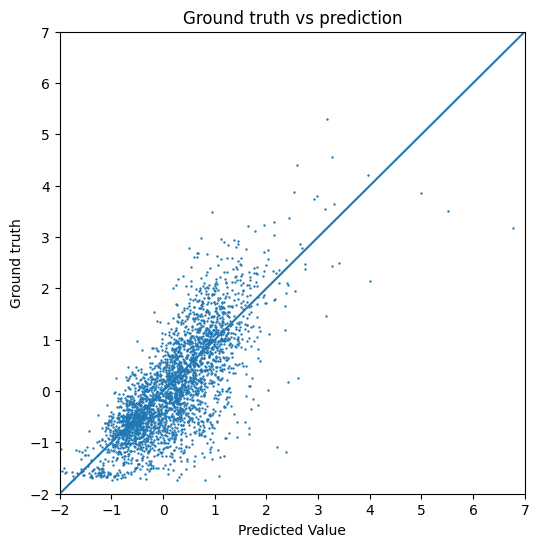

In [22]:
# Calculate test loss from the best GIN model (according to validation loss)

# load our model
model = GIN(dim_h=64)
model.load_state_dict(torch.load("/content/GIN_model.pt"))

# calculate test loss
gin_test_loss, gin_test_target, gin_test_y = testing(test_loader, model)

print("Test Loss for GIN: " + str(gin_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gin_test_target, gin_test_y)